In [42]:
import pandas as pd
vix_daily = pd.read_csv("Data/VIXCLS-2.csv", parse_dates=["observation_date"], index_col="observation_date")
vix_daily.rename(columns={"observation_date": "date"}, inplace=True)
vix_daily.rename(columns={"VIXCLS": "VIX"}, inplace=True)
vix = vix_daily.resample('M').mean()
vix.index = vix.index.to_period('M')
vix.index.name ="date"
returns = pd.read_pickle("Data/long_short_returns.pkl")

credit_spread_daily = pd.read_csv("Data/BAA10Y.csv", parse_dates=['observation_date'], index_col='observation_date')
credit_spread = credit_spread_daily.resample('M').mean()
credit_spread.index = credit_spread.index.to_period('M')
credit_spread = credit_spread/100
credit_spread.index.name = 'date'
credit_spread.rename(columns={"BAA10Y": "Credit_Spread"}, inplace=True)


df = pd.concat([returns, vix, credit_spread], axis=1, join="inner")
df

/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_56786/802782135.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vix = vix_daily.resample('M').mean()
/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_56786/802782135.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  credit_spread = credit_spread_daily.resample('M').mean()


,long_short_ret,VIX,Credit_Spread
date,,,
1990-01,0.013768,23.347273,0.017386
1990-02,-0.008227,23.262632,0.016711
1990-03,-0.012210,20.062273,0.016182
1990-04,-0.007258,21.403500,0.015160
1990-05,-0.034067,18.097727,0.016532
...,...,...,...
2018-02,-0.001483,22.464737,0.016500
2018-03,0.018226,19.023810,0.017976
2018-04,0.011251,18.267619,0.018000


In [44]:
import pandas as pd
import statsmodels.api as sm


# Define a high risk aversion dummy based on VIX (e.g., above median)
df['high_vix'] = (df['VIX'] > df['VIX'].median()).astype(int)

# Interaction term
df['value_x_vix'] = df['long_short_ret'] * df['high_vix']

# High credit spread dummy (above median)
df['high_cs'] = (df['Credit_Spread'] > df['Credit_Spread'].median()).astype(int)

# Interaction with value premium
df['value_x_cs'] = df['long_short_ret'] * df['high_cs']

# Regression: value premium on high_vix dummy and interaction
#X = sm.add_constant(df[['high_vix', 'value_x_vix']])
X = sm.add_constant(df[['high_vix', 'value_x_vix', 'high_cs', 'value_x_cs']])
y = df['long_short_ret']

model = sm.OLS(y, X).fit(cov_type="HC3")
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         long_short_ret   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     790.7
Date:                Fri, 20 Jun 2025   Prob (F-statistic):          8.25e-170
Time:                        18:07:04   Log-Likelihood:                 1052.1
No. Observations:                 342   AIC:                            -2094.
Df Residuals:                     337   BIC:                            -2075.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0038      0.001      2.969      

In [45]:
high_vix_returns = df.loc[df['high_vix'] == 1, 'long_short_ret']
low_vix_returns = df.loc[df['high_vix'] == 0, 'long_short_ret']

print("Mean Value Premium when VIX is High:", high_vix_returns.mean())
print("Mean Value Premium when VIX is Low:", low_vix_returns.mean())


Mean Value Premium when VIX is High: 0.0034113631146352017
Mean Value Premium when VIX is Low: 0.0035089463359813298


The average difference in raw returns between just “high VIX” vs. “low VIX” months (ignoring factor levels) is indeed very small (~0.1%).
However, the effect of the value premium on returns is much stronger in the high VIX regime.
In other words, risk aversion regimes don’t change the baseline returns much directly, but they amplify or dampen how much the value factor translates into actual returns.

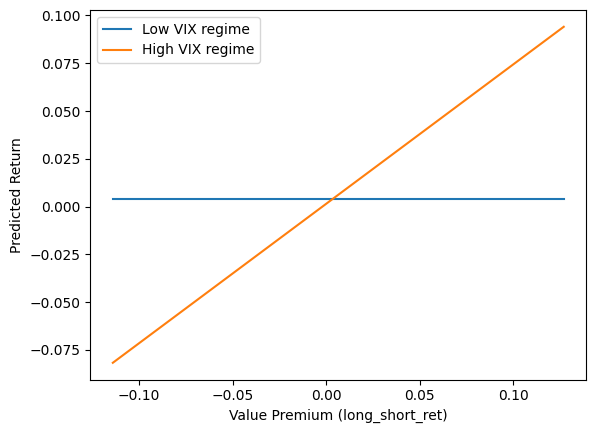

In [46]:
import numpy as np

# Create a grid of value premium factor values
vp_vals = np.linspace(df['long_short_ret'].min(), df['long_short_ret'].max(), 100)

# Predict returns for low and high VIX (high_vix=0 or 1)
low_vix_returns = model.params['const'] + model.params['value_x_vix'] * 0 + model.params['high_vix'] * 0 + model.params['value_x_vix'] * 0 * vp_vals + model.params['high_vix'] * 0
high_vix_returns = model.params['const'] + model.params['high_vix'] * 1 + model.params['value_x_vix'] * vp_vals

import matplotlib.pyplot as plt
plt.plot(vp_vals, low_vix_returns, label='Low VIX regime')
plt.plot(vp_vals, high_vix_returns, label='High VIX regime')
plt.xlabel('Value Premium (long_short_ret)')
plt.ylabel('Predicted Return')
plt.legend()
plt.show()
